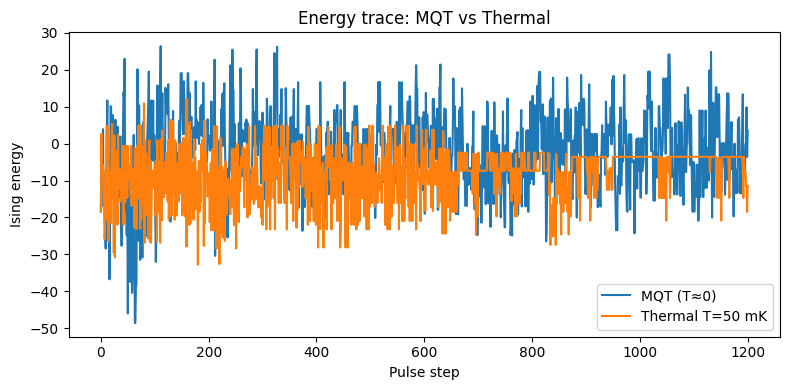

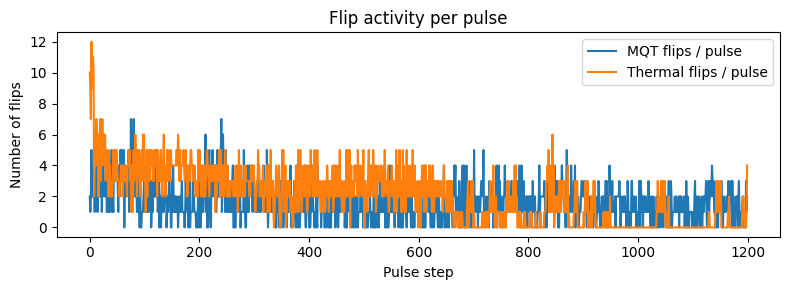

MQT best energy: -48.56342125632089
Thermal best energy: -32.8296199064308


In [1]:
# jj_annealer_simulation.py
# A self-contained simulation of a Josephson-junction-inspired annealer for Ising problems.
# Requires: numpy, matplotlib
# Save as src/simulator.py or run directly.

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi

# -----------------------------
# Physical constants (SI)
# -----------------------------
hbar = 1.054571817e-34
e = 1.602176634e-19
phi0 = (6.62607015e-34) / (2*e)
kb = 1.380649e-23

# -----------------------------
# JJ device params (tunable)
# -----------------------------
Ic = 1.0e-6      # [A]
C  = 1.0e-12     # [F]
EJ = phi0 * Ic / (2*np.pi)

# Helper functions
def omega_p(i_reduced, Ic=Ic, C=C):
    i = np.clip(i_reduced, 0.0, 0.999999)
    return np.sqrt(2*e*Ic/(hbar*C)) * (1 - i**2)**0.25

def delta_U(i_reduced, EJ=EJ):
    i = np.clip(i_reduced, 0.0, 0.999999)
    return 2*EJ * (np.sqrt(1 - i**2) - i*np.arccos(i))

def gamma_th(i_reduced, T, Ic=Ic, C=C):
    op = omega_p(i_reduced, Ic, C)
    dU = delta_U(i_reduced, EJ)
    # Kramers prefactor ~ ω_p / 2π (underdamped simplified)
    return (op/(2*np.pi)) * np.exp(- dU / (kb * T))

def gamma_mqt(i_reduced, Ic=Ic, C=C):
    op = omega_p(i_reduced, Ic, C)
    dU = delta_U(i_reduced, EJ)
    # Cubic-potential WKB prefactor/exponent (approx)
    pref = (op/(2*np.pi)) * np.sqrt(864.0 * dU / (hbar * op))
    expo = np.exp(-36.0 * dU / (5.0 * hbar * op))
    return pref * expo

def P_switch(i_reduced, pulse_s, T=None):
    gamma = gamma_mqt(i_reduced) if (T is None) else gamma_th(i_reduced, T)
    # protect against overflow/underflow
    lam = gamma * pulse_s
    lam = np.clip(lam, 0, 50.0)
    return 1.0 - np.exp(-lam)

# -----------------------------
# Ising problem generator
# -----------------------------
def random_ising(N, p_edge=0.3, J_scale=1.0, seed=None):
    rng = np.random.default_rng(seed)
    J = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1, N):
            if rng.random() < p_edge:
                val = rng.normal(loc=0.0, scale=J_scale)
                J[i,j] = val
                J[j,i] = val
    h = rng.normal(0.0, 0.1, size=N)
    return J, h

def ising_energy(s, J, h):
    # s: +/-1
    return -0.5 * s @ J @ s - h @ s

# -----------------------------
# Mapping local field -> reduced bias i in [0, 0.9999]
# -----------------------------
def local_field_to_reduced_bias(h_eff, i0=0.5, alpha=0.45, beta=1.0):
    # h_eff can be large; use tanh to saturate
    return np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)

# -----------------------------
# Simulator: pulse-step Monte Carlo
# -----------------------------
def run_simulation(J, h, n_steps=2000, pulse_s=10e-6, T=None,
                   i0=0.5, alpha=0.45, beta=1.0, seed=None, verbose=False):
    rng = np.random.default_rng(seed)
    N = len(h)
    # initial random spins (+1 / -1)
    s = rng.choice([-1, 1], size=N)
    energies = []
    best_E = ising_energy(s, J, h)
    best_s = s.copy()
    energies.append(best_E)
    flips_record = np.zeros(n_steps)

    for t in range(n_steps):
        # compute local effective fields for each spin
        h_eff = J @ s + h  # local fields
        # map to reduced bias (higher field -> higher bias -> higher escape P)
        i_reduced = local_field_to_reduced_bias(h_eff, i0=i0, alpha=alpha, beta=beta)
        # compute switch probabilities (vectorized)
        if T is None:
            P = np.array([P_switch(i_reduced[i], pulse_s, T=None) for i in range(N)])
        else:
            P = np.array([P_switch(i_reduced[i], pulse_s, T=T) for i in range(N)])
        # decide which junctions flip (trial flips)
        rand = rng.random(size=N)
        flips = (rand < P)
        flips_record[t] = flips.sum()
        # apply flips: flipping a spin s_i -> -s_i
        s[flips] *= -1
        E = ising_energy(s, J, h)
        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()
        if verbose and (t % max(1, n_steps//10) == 0):
            print(f"[{t}/{n_steps}] E={E:.3f} best={best_E:.3f} flips={flips.sum()}")
    return {
        'energies': np.array(energies),
        'best_E': best_E,
        'best_s': best_s,
        'final_s': s,
        'flips_record': flips_record
    }

# -----------------------------
# Example run & plotting
# -----------------------------
def example_run():
    N = 64
    J, h = random_ising(N, p_edge=0.1, J_scale=1.0, seed=42)
    # Two runs: MQT (T=None) vs Thermal (T=0.05 K)
    res_q = run_simulation(J, h, n_steps=1200, pulse_s=10e-6, T=None, seed=1)
    res_th = run_simulation(J, h, n_steps=1200, pulse_s=10e-6, T=0.05, seed=1)

    plt.figure(figsize=(8,4))
    plt.plot(res_q['energies'], label='MQT (T≈0)')
    plt.plot(res_th['energies'], label='Thermal T=50 mK')
    plt.xlabel('Pulse step')
    plt.ylabel('Ising energy')
    plt.legend()
    plt.title('Energy trace: MQT vs Thermal')
    plt.tight_layout()
    plt.show()

    # histogram of flips
    plt.figure(figsize=(8,3))
    plt.plot(res_q['flips_record'], label='MQT flips / pulse')
    plt.plot(res_th['flips_record'], label='Thermal flips / pulse')
    plt.xlabel('Pulse step')
    plt.ylabel('Number of flips')
    plt.legend()
    plt.title('Flip activity per pulse')
    plt.tight_layout()
    plt.show()

    print("MQT best energy:", res_q['best_E'])
    print("Thermal best energy:", res_th['best_E'])

if __name__ == "__main__":
    example_run()


In [ ]:
%%writefile jj_physics.py
"""
jj_physics.py

Josephson-junction physics utilities:
- plasma frequency omega_p(i)
- washboard barrier delta_U(i)
- thermal escape rate gamma_th(i, T)
- macroscopic quantum tunnelling rate gamma_mqt(i)
- switching probability P_switch(i, t_p, T=None)

All formulas use SI units.
"""

from typing import Optional
import numpy as np

# Physical constants (SI)
h = 6.62607015e-34          # Planck constant [J·s]
hbar = 1.054571817e-34      # Reduced Planck constant [J·s]
e = 1.602176634e-19         # Elementary charge [C]
phi0 = h / (2 * e)          # Flux quantum [Wb]
kb = 1.380649e-23           # Boltzmann constant [J/K]

# Default device parameters (tunable)
DEFAULT_Ic = 1.0e-6    # Critical current [A]
DEFAULT_C  = 1.0e-12   # Junction capacitance [F]
DEFAULT_EJ = phi0 * DEFAULT_Ic / (2 * np.pi)


def omega_p(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C) -> float:
    """
    Plasma angular frequency ω_p(i) [rad/s] at reduced bias i = I/Ic.
    Uses underdamped tunnel-junction approximation:
      ω_p(i) = sqrt(2 e Ic / (ħ C)) * (1 - i^2)^(1/4)
    """
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return np.sqrt(2.0 * e * Ic / (hbar * C)) * (1.0 - i**2)**0.25


def delta_U(i_reduced: float, EJ: float = DEFAULT_EJ) -> float:
    """
    Washboard barrier height ΔU(i) [J] for a current-biased JJ:
      ΔU(i) = 2 EJ [ sqrt(1 - i^2) - i arccos(i) ]
    Valid for 0 <= i < 1.
    """
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return 2.0 * EJ * (np.sqrt(1.0 - i**2) - i * np.arccos(i))


def gamma_th(i_reduced: float, T: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
             EJ: float = DEFAULT_EJ) -> float:
    """
    Thermal (Kramers-like) escape rate Γ_th [1/s]:
      Γ_th ≈ (ω_p / 2π) * exp(-ΔU / (k_B T))
    Underdamped prefactor used (damping not explicitly included).
    """
    if T <= 0.0:
        return 0.0
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    exponent = - dU / (kb * T)
    # Avoid overflow / underflow for extreme numbers
    if exponent < -700:
        return 0.0
    return (op / (2.0 * np.pi)) * np.exp(exponent)


def gamma_mqt(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
              EJ: float = DEFAULT_EJ) -> float:
    """
    Macroscopic Quantum Tunneling (MQT) escape rate Γ_MQT [1/s], cubic-potential WKB approximation:
      Γ_MQT ≈ (ω_p / 2π) * sqrt(864 ΔU / (ħ ω_p)) * exp( -36 ΔU / (5 ħ ω_p) )
    """
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    arg = 36.0 * dU / (5.0 * hbar * op)
    if arg > 700:  # exponent too large -> rate virtually zero
        return 0.0
    # guard small denominators
    factor = max(1e-300, (864.0 * dU) / (hbar * op))
    pref = (op / (2.0 * np.pi)) * np.sqrt(factor)
    return pref * np.exp(-arg)


def P_switch(i_reduced: float, pulse_s: float, T: Optional[float] = None,
             Ic: float = DEFAULT_Ic, C: float = DEFAULT_C, EJ: float = DEFAULT_EJ,
             hbar_eff: float = hbar) -> float:
    if pulse_s <= 0.0:
        return 0.0
    gamma = gamma_mqt(i_reduced, Ic=Ic, C=C, EJ=EJ, hbar_eff=hbar_eff) if T is None \
            else gamma_th(i_reduced, T, Ic=Ic, C=C, EJ=EJ)
    lam = gamma * pulse_s
    lam = float(np.clip(lam, 0.0, 50.0))
    return 1.0 - np.exp(-lam)


def crossover_temperature(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C) -> float:
    """
    Rule-of-thumb crossover temperature T* ~ ħ ω_p / (2π k_B) at reduced bias i.
    Returns T* in Kelvins.
    """
    op = omega_p(i_reduced, Ic=Ic, C=C)
    return (hbar * op) / (2.0 * np.pi * kb)
def gamma_mqt(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
              EJ: float = DEFAULT_EJ, hbar_eff: float = hbar) -> float:
    """
    Macroscopic Quantum Tunneling (MQT) escape rate with tunable effective Planck constant.
    """
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    arg = 36.0 * dU / (5.0 * hbar_eff * op)
    if arg > 700:  # exponent too large -> rate virtually zero
        return 0.0
    factor = max(1e-300, (864.0 * dU) / (hbar_eff * op))
    pref = (op / (2.0 * np.pi)) * np.sqrt(factor)
    return pref * np.exp(-arg)


Overwriting jj_physics.py


In [ ]:
%%writefile ising_map.py
"""
ising_map.py

Utilities for mapping combinatorial optimization problems to Ising form
and computing objective values.

- graph_to_Ising_J(A): converts adjacency matrix A for Max-Cut into Ising coupling J
- cut_value(s, A): computes Max-Cut value for spin vector s in {+1,-1}
- ising_energy(s, J, h=None): computes Ising energy E = -0.5 s^T J s - h^T s
- random_weighted_graph(N, p_edge, w_scale): generate random weighted graph adjacency
"""

from typing import Optional, Tuple
import numpy as np


def graph_to_Ising_J(adj_matrix: np.ndarray) -> np.ndarray:
    """
    Convert adjacency matrix A (symmetric, zero diagonal) for Max-Cut into Ising coupling J.
    For Max-Cut we can use J = -A so that minimizing E_ising = -0.5 s^T J s corresponds to maximizing the cut.
    """
    A = np.array(adj_matrix, dtype=float)
    if A.shape[0] != A.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    J = -A.copy()
    np.fill_diagonal(J, 0.0)
    return J


def cut_value(s: np.ndarray, A: np.ndarray) -> float:
    """
    Compute Max-Cut value for spin vector s ∈ {+1, -1} and adjacency A:
      cut = 0.5 * sum_{i<j} A_ij (1 - s_i s_j)
    """
    s = np.array(s, dtype=int).reshape(-1)
    A = np.array(A, dtype=float)
    N = s.size
    if A.shape != (N, N):
        raise ValueError("Adjacency matrix size must match spin vector length.")
    # Efficient vectorized computation:
    # cut = 0.25 * sum_{i,j} A_ij (1 - s_i s_j)  (since each pair counted twice)
    return 0.25 * np.sum(A * (1.0 - np.outer(s, s)))


def ising_energy(s: np.ndarray, J: np.ndarray, h: Optional[np.ndarray] = None) -> float:
    """
    Compute Ising energy:
      E = -0.5 * s^T J s - h^T s
    """
    s = np.array(s, dtype=float).reshape(-1)
    J = np.array(J, dtype=float)
    if h is None:
        h = np.zeros_like(s)
    return -0.5 * float(s @ J @ s) - float(np.dot(h, s))


def random_weighted_graph(N: int, p_edge: float = 0.3, w_scale: float = 1.0, seed: Optional[int] = None) -> np.ndarray:
    """
    Generate a symmetric random weighted adjacency matrix A (zero diagonal).
    - N: number of nodes
    - p_edge: probability of an edge between i and j
    - w_scale: weight scaling factor (weights drawn ~ Uniform(0.5, 1.5) * w_scale)
    """
    rng = np.random.default_rng(seed)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i + 1, N):
            if rng.random() < p_edge:
                val = rng.uniform(0.5, 1.5) * w_scale
                A[i, j] = val
                A[j, i] = val
    return A


Overwriting ising_map.py


Finished runs: MQT time=0.85s Thermal time=0.78s SA time=0.02s
SA final cut (direct): 45.4301


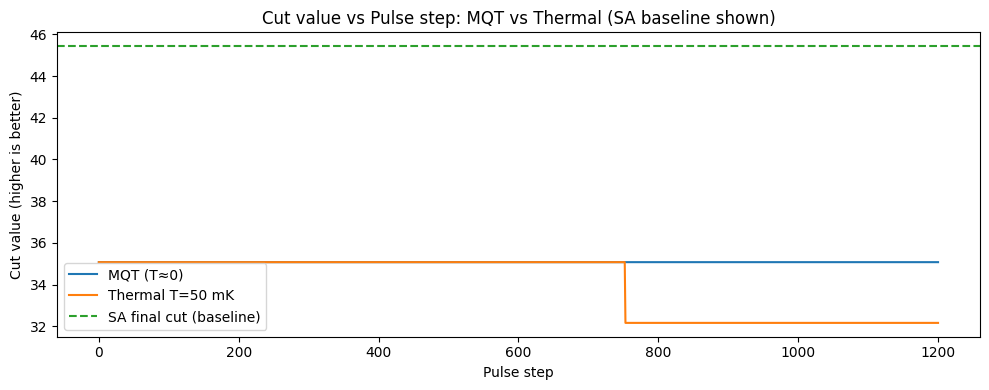

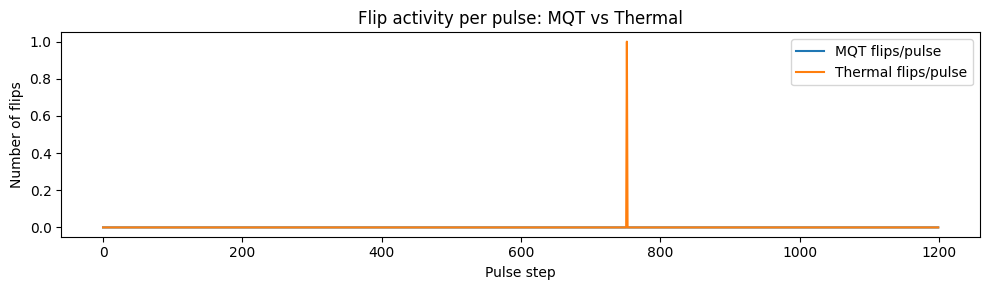

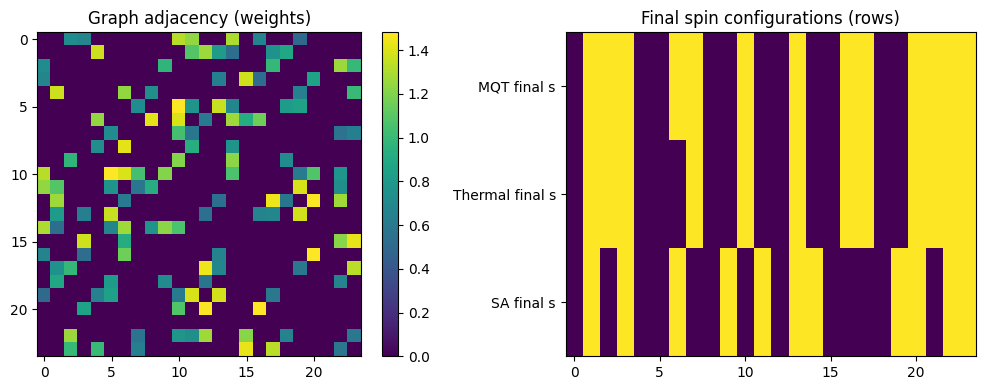

Summary:
MQT best cut: 35.0785  final cut: 35.0785
Thermal best cut: 35.0785  final cut: 32.1679
SA final cut: 45.4301  SA best E: -24.4176


In [ ]:
"""
simulator.py

High-level simulator that uses jj_physics and ising_map to:
- Run a JJ-array pulse-based annealer (MQT or thermal)
- Run a classical Simulated Annealing baseline
- Provide an example experiment for Max-Cut on a random weighted graph

Run: python simulator.py
"""

import numpy as np
import matplotlib.pyplot as plt
import time
from jj_physics import hbar
from jj_physics import P_switch, kb, hbar

from typing import Optional, Dict

from jj_physics import P_switch  # expects jj_physics.py in same module path
from ising_map import graph_to_Ising_J, ising_energy, cut_value, random_weighted_graph

# -----------------------------
# Mapping: local effective field -> reduced bias i in [0, 0.9999]
# -----------------------------
def local_field_to_reduced_bias(h_eff: np.ndarray, i0: float = 0.5, alpha: float = 0.45, beta: float = 1.0) -> np.ndarray:
    """
    Map local effective field (real numbers) to reduced bias i = I/Ic in [0, 0.9999].
    Uses a saturated tanh mapping; parameters tune sensitivity.
    """
    h_eff = np.array(h_eff, dtype=float)
    return np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)


# -----------------------------
# JJ-array pulse-step Monte Carlo simulator
# -----------------------------
def jj_array_simulator(J: np.ndarray,
                       h: Optional[np.ndarray] = None,
                       pulse_s: float = 10e-6,
                       T: Optional[float] = None,
                       i0: float = 0.5,
                       alpha: float = 0.45,
                       beta: float = 1.0,
                       n_steps: int = 2000,
                       seed: Optional[int] = None,
                       verbose: bool = False) -> Dict:
    """
    Run a pulse-based JJ-array annealer.
    - J: Ising coupling matrix (N x N)
    - h: local fields (N,), optional
    - pulse_s: pulse length [s]
    - T: temperature in Kelvin (if None -> quantum (MQT) regime)
    - i0, alpha, beta: mapping parameters
    - n_steps: number of pulses
    Returns dict with energies, cut_vals, best_cut, best_s, flips_record, final_s
    """
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    energies = []
    cut_vals = []
    best_cut = cut_value(s, -J)  # recall for Max-Cut mapping J = -A
    best_s = s.copy()
    energies.append(ising_energy(s, J, h))
    cut_vals.append(best_cut)
    flips_record = np.zeros(n_steps, dtype=int)

    for t in range(n_steps):
        h_eff = J @ s + h  # local effective field
        i_reduced = local_field_to_reduced_bias(h_eff, i0=i0, alpha=alpha, beta=beta)
        # vectorized P_switch calls (loop here for safety because P_switch accepts scalar)
        P = np.array([P_switch(float(i_reduced[i]), pulse_s, T) for i in range(N)])
        rand = rng.random(size=N)
        flips = (rand < P)
        flips_record[t] = int(flips.sum())
        s[flips] *= -1
        E = ising_energy(s, J, h)
        energies.append(E)
        cutv = cut_value(s, -J)
        cut_vals.append(cutv)
        if cutv > best_cut:
            best_cut = cutv
            best_s = s.copy()
        if verbose and (t % max(1, n_steps // 10) == 0):
            print(f"[{t}/{n_steps}] cut={cutv:.4f} best_cut={best_cut:.4f} flips={flips_record[t]}")
    return {
        'energies': np.array(energies),
        'cut_vals': np.array(cut_vals),
        'best_cut': float(best_cut),
        'best_s': best_s,
        'final_s': s,
        'flips_record': flips_record
    }


# -----------------------------
# Classical Simulated Annealing baseline
# -----------------------------
def simulated_annealing(J: np.ndarray,
                        h: Optional[np.ndarray] = None,
                        T_start: float = 1.0,
                        T_end: float = 0.01,
                        n_steps: int = 2000,
                        seed: Optional[int] = None) -> Dict:
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    E = ising_energy(s, J, h)
    best_E = E
    best_s = s.copy()
    energies = [E]
    temps = np.linspace(T_start, T_end, n_steps)
    for t, T in enumerate(temps):
        i = rng.integers(0, N)
        s_new = s.copy()
        s_new[i] *= -1
        E_new = ising_energy(s_new, J, h)
        dE = E_new - E
        if dE < 0 or rng.random() < np.exp(-dE / (kb * max(T, 1e-300))):
            s = s_new
            E = E_new
        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()
    return {
        'energies': np.array(energies),
        'best_E': float(best_E),
        'best_s': best_s,
        'final_s': s
    }



# -----------------------------
# Example experiment (Max-Cut) when run as script
# -----------------------------
def example_experiment():
    # Graph parameters
    N = 24
    A = random_weighted_graph(N, p_edge=0.25, w_scale=1.0, seed=123)
    J = graph_to_Ising_J(A)  # J = -A for Max-Cut mapping

    # Simulator parameters
    pulse_s = 10e-6
    n_steps = 1200
    i0 = 0.5
    alpha = 0.42
    beta = 1.0

    # Run MQT (quantum-dominated)
    t0 = time.time()
    res_mqt = jj_array_simulator(J, pulse_s=pulse_s, T=None, i0=i0, alpha=alpha, beta=beta,
                                 n_steps=n_steps, seed=1, verbose=False)
    t_mqt = time.time() - t0

    # Run Thermal (classical thermal escapes at 50 mK)
    t0 = time.time()
    res_th = jj_array_simulator(J, pulse_s=pulse_s, T=0.05, i0=i0, alpha=alpha, beta=beta,
                                n_steps=n_steps, seed=1, verbose=False)
    t_th = time.time() - t0

    # Run Simulated Annealing baseline
    t0 = time.time()
    res_sa = simulated_annealing(J, T_start=1.0, T_end=0.001, n_steps=n_steps, seed=1)
    t_sa = time.time() - t0

    print(f"Finished runs: MQT time={t_mqt:.2f}s Thermal time={t_th:.2f}s SA time={t_sa:.2f}s")
    cut_sa = cut_value(res_sa['final_s'], A)
    print(f"SA final cut (direct): {cut_sa:.4f}")

    # Plot cut traces
    plt.figure(figsize=(10, 4))
    plt.plot(res_mqt['cut_vals'], label='MQT (T≈0)')
    plt.plot(res_th['cut_vals'], label='Thermal T=50 mK')
    plt.axhline(y=cut_sa, color='C2', linestyle='--', label='SA final cut (baseline)')
    plt.xlabel('Pulse step')
    plt.ylabel('Cut value (higher is better)')
    plt.title('Cut value vs Pulse step: MQT vs Thermal (SA baseline shown)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot flips per pulse
    plt.figure(figsize=(10, 3))
    plt.plot(res_mqt['flips_record'], label='MQT flips/pulse')
    plt.plot(res_th['flips_record'], label='Thermal flips/pulse')
    plt.xlabel('Pulse step')
    plt.ylabel('Number of flips')
    plt.title('Flip activity per pulse: MQT vs Thermal')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Adjacency and final spin configs
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(A, interpolation='nearest')
    plt.title('Graph adjacency (weights)')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    combined = np.vstack([res_mqt['final_s'], res_th['final_s'], res_sa['final_s']])
    plt.imshow(combined, aspect='auto', interpolation='nearest')
    plt.yticks([0, 1, 2], ['MQT final s', 'Thermal final s', 'SA final s'])
    plt.title('Final spin configurations (rows)')
    plt.tight_layout()
    plt.show()

    print("Summary:")
    print(f"MQT best cut: {res_mqt['best_cut']:.4f}  final cut: {res_mqt['cut_vals'][-1]:.4f}")
    print(f"Thermal best cut: {res_th['best_cut']:.4f}  final cut: {res_th['cut_vals'][-1]:.4f}")
    print(f"SA final cut: {cut_sa:.4f}  SA best E: {res_sa['best_E']:.4f}")


# small helper imports used in example_experiment (to avoid circular imports)
from ising_map import random_weighted_graph, graph_to_Ising_J  # noqa: E402
from ising_map import cut_value  # noqa: E402
from jj_physics import kb  # noqa: E402
import time  # noqa: E402

if __name__ == "__main__":
    example_experiment()


In [2]:
!pip install pennylane numpy networkx matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.3 MB/s eta 0:00:00


Step    0: E = 3.622011
Step   15: E = -0.229181
Step   30: E = -1.657823
Step   45: E = -1.689455
Step   60: E = -1.759800
Step   75: E = -1.856093
Step   90: E = -2.027039
Step  105: E = -2.198372
Step  120: E = -2.260401
Step  135: E = -2.276524

Final estimated ground energy: -2.280269


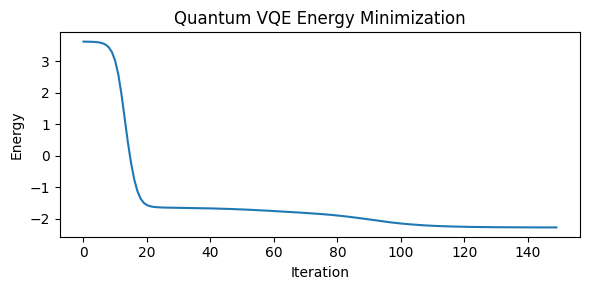

In [ ]:
# quantum_solver.py
"""
Quantum optimization of Ising problems using PennyLane (VQE approach).
Uses the same J, h from the JJ simulation (ising_map.py).
"""

import pennylane as qml
from pennylane import numpy as np
from ising_map import random_weighted_graph, graph_to_Ising_J, ising_energy
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Helper: convert Ising problem to PennyLane Hamiltonian
# -------------------------------------------------------
def ising_to_hamiltonian(J: np.ndarray, h: np.ndarray):
    N = len(h)
    coeffs = []
    ops = []
    for i in range(N):
        coeffs.append(-h[i])
        ops.append(qml.PauliZ(i))
        for j in range(i + 1, N):
            if J[i, j] != 0:
                coeffs.append(-0.5 * J[i, j])
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    return qml.Hamiltonian(coeffs, ops)


# -------------------------------------------------------
# Define VQE circuit (hardware-efficient ansatz)
# -------------------------------------------------------
def make_vqe_solver(J, h, layers=3, shots=None, device_type="default.qubit"):
    N = len(h)
    H = ising_to_hamiltonian(J, h)
    dev = qml.device(device_type, wires=N, shots=shots)

    @qml.qnode(dev)
    def circuit(params):
        qml.StronglyEntanglingLayers(params, wires=range(N))
        return qml.expval(H)

    return circuit, H, dev


# -------------------------------------------------------
# Quantum optimization routine
# -------------------------------------------------------
def quantum_optimize(J, h, layers=3, steps=200, lr=0.2, seed=42):
    np.random.seed(seed)
    N = len(h)
    circuit, H, dev = make_vqe_solver(J, h, layers=layers)
    params = 0.01 * np.random.randn(layers, N, 3)

    opt = qml.GradientDescentOptimizer(lr)
    energies = []

    for step in range(steps):
        params, cost = opt.step_and_cost(circuit, params)
        energies.append(cost)
        if step % max(1, steps // 10) == 0:
            print(f"Step {step:4d}: E = {cost:.6f}")

    return {
        "final_params": params,
        "final_energy": energies[-1],
        "energy_trace": np.array(energies),
        "Hamiltonian": H,
        "device": dev
    }


# -------------------------------------------------------
# Example experiment (parallel to your JJ simulator)
# -------------------------------------------------------
def example_run():
    # Create a small Ising problem
    N = 6
    A = random_weighted_graph(N, p_edge=0.5, w_scale=1.0, seed=123)
    J = graph_to_Ising_J(A)
    h = np.zeros(N)

    # Run the quantum optimizer
    res = quantum_optimize(J, h, layers=3, steps=150, lr=0.15)
    print(f"\nFinal estimated ground energy: {res['final_energy']:.6f}")

    # Plot energy trace
    plt.figure(figsize=(6, 3))
    plt.plot(res["energy_trace"])
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.title("Quantum VQE Energy Minimization")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    example_run()



PLATEAU benchmark (10 qubits)
J shape: (10, 10)
h shape: (10,)


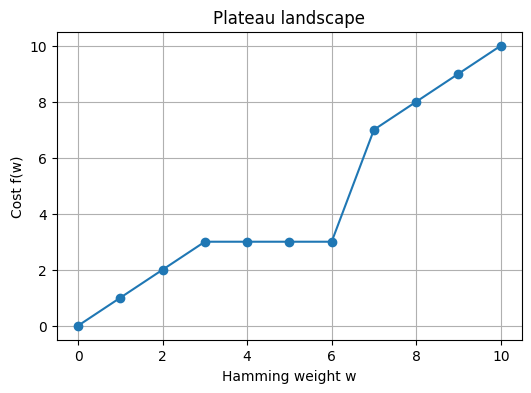


SPIKE benchmark (10 qubits)
J shape: (10, 10)
h shape: (10,)


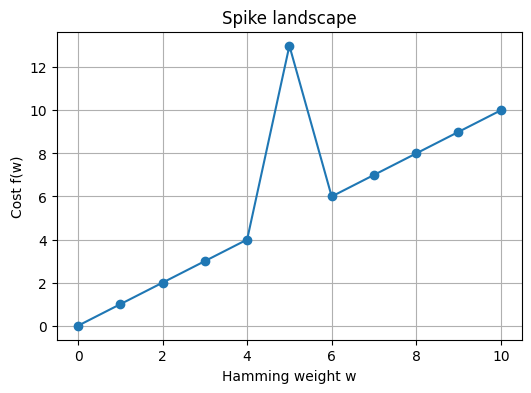


RAMP benchmark (10 qubits)
J shape: (10, 10)
h shape: (10,)


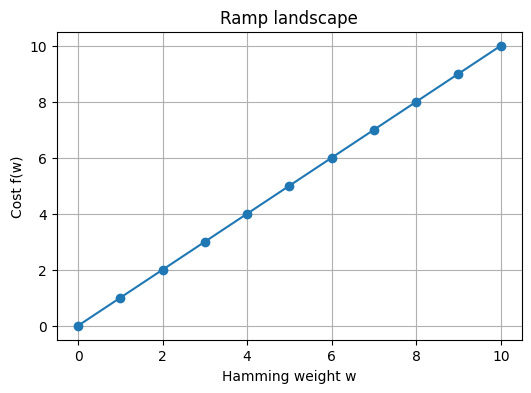

In [ ]:
"""
Permutation-symmetric benchmark problems for quantum optimization,
integrated with JJ annealer + PennyLane solvers.

Implements cost functions from:
Muthukrishnan, Albash, & Lidar (2015),
'Tunneling and speedup in quantum optimization for permutation-symmetric problems'
(arXiv:1511.03910)
"""

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import Tuple, Dict

# ----------------------------------------------------------
# 1. Permutation-symmetric cost functions
# ----------------------------------------------------------

def fixed_plateau(x: np.ndarray, l: int = 3, u: int = 6) -> float:
    """
    Fixed Plateau function from Eq. (14) of the paper.
    Cost depends only on Hamming weight w = sum(x_i)
    """
    w = np.sum(x)
    if l <= w <= u:
        return u - l  # constant plateau region
    else:
        return w


def spike(x: np.ndarray, spike_height: float = 10.0, spike_pos: int = 5) -> float:
    """
    Spike cost function with a single sharp barrier in Hamming weight space.
    """
    w = np.sum(x)
    if w == spike_pos:
        return w + spike_height
    return w


def hamming_ramp(x: np.ndarray) -> float:
    """
    Simple linear ramp cost = Hamming weight.
    (Used as a control problem without tunneling barrier.)
    """
    return np.sum(x)


# ----------------------------------------------------------
# 2. Convert symmetric cost function → Ising (J, h)
# ----------------------------------------------------------

def symmetric_to_ising(N: int, cost_fn) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a permutation-symmetric cost function f(x) to
    equivalent Ising couplings J, h by fitting over all bitstrings.
    """
    states = np.array(list(product([0, 1], repeat=N)))
    energies = np.array([cost_fn(x) for x in states])
    spins = 1 - 2 * states  # map {0,1} → {+1,-1}

    # Fit Ising model: E = -∑ h_i s_i - ∑_ij J_ij s_i s_j / 2
    h = np.zeros(N)
    J = np.zeros((N, N))

    for i in range(N):
        h[i] = -0.25 * np.dot(spins[:, i], energies) / len(states)
        for j in range(i + 1, N):
            J[i, j] = -0.25 * np.dot(spins[:, i] * spins[:, j], energies) / len(states)
            J[j, i] = J[i, j]
    return J, h


# ----------------------------------------------------------
# 3. Visualization utilities
# ----------------------------------------------------------

def plot_cost_vs_hamming(cost_fn, N=10, title="Cost Landscape"):
    ws = np.arange(0, N + 1)
    costs = [cost_fn(np.array([1]*w + [0]*(N-w))) for w in ws]
    plt.figure(figsize=(6, 4))
    plt.plot(ws, costs, "-o")
    plt.xlabel("Hamming weight w")
    plt.ylabel("Cost f(w)")
    plt.title(title)
    plt.grid(True)
    plt.show()


# ----------------------------------------------------------
# 4. Benchmark generator
# ----------------------------------------------------------

def load_benchmark(name: str, N: int = 8) -> Dict:
    """
    Load a predefined permutation-symmetric benchmark.
    Returns dict with J, h, and metadata.
    """
    if name.lower() == "plateau":
        fn = lambda x: fixed_plateau(x, l=int(0.3*N), u=int(0.6*N))
    elif name.lower() == "spike":
        fn = lambda x: spike(x, spike_height=8, spike_pos=int(0.5*N))
    elif name.lower() == "ramp":
        fn = hamming_ramp
    else:
        raise ValueError("Unknown benchmark: choose from ['plateau', 'spike', 'ramp']")

    J, h = symmetric_to_ising(N, fn)
    return {
        "J": J,
        "h": h,
        "cost_fn": fn,
        "N": N,
        "name": name
    }


# ----------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------

if __name__ == "__main__":
    N = 10
    for name in ["plateau", "spike", "ramp"]:
        bench = load_benchmark(name, N)
        print(f"\n{name.upper()} benchmark ({N} qubits)")
        print("J shape:", bench["J"].shape)
        print("h shape:", bench["h"].shape)
        plot_cost_vs_hamming(bench["cost_fn"], N, title=f"{name.capitalize()} landscape")


In [ ]:
%%writefile symmetry_benchmarks.py
"""
Permutation-symmetric benchmark problems for quantum optimization,
integrated with JJ annealer + PennyLane solvers.

Implements cost functions from:
Muthukrishnan, Albash, & Lidar (2015),
'Tunneling and speedup in quantum optimization for permutation-symmetric problems'
(arXiv:1511.03910)
"""

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import Tuple, Dict

# ----------------------------------------------------------
# 1. Permutation-symmetric cost functions
# ----------------------------------------------------------

def fixed_plateau(x: np.ndarray, l: int = 3, u: int = 6) -> float:
    """
    Fixed Plateau function from Eq. (14) of the paper.
    Cost depends only on Hamming weight w = sum(x_i)
    """
    w = np.sum(x)
    if l <= w <= u:
        return u - l  # constant plateau region
    else:
        return w


def spike(x: np.ndarray, spike_height: float = 10.0, spike_pos: int = 5) -> float:
    """
    Spike cost function with a single sharp barrier in Hamming weight space.
    """
    w = np.sum(x)
    if w == spike_pos:
        return w + spike_height
    return w


def hamming_ramp(x: np.ndarray) -> float:
    """
    Simple linear ramp cost = Hamming weight.
    (Used as a control problem without tunneling barrier.)
    """
    return np.sum(x)


# ----------------------------------------------------------
# 2. Convert symmetric cost function → Ising (J, h)
# ----------------------------------------------------------

def symmetric_to_ising(N: int, cost_fn) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a permutation-symmetric cost function f(x) to
    equivalent Ising couplings J, h by fitting over all bitstrings.
    """
    states = np.array(list(product([0, 1], repeat=N)))
    energies = np.array([cost_fn(x) for x in states])
    spins = 1 - 2 * states  # map {0,1} → {+1,-1}

    # Fit Ising model: E = -∑ h_i s_i - ∑_ij J_ij s_i s_j / 2
    h = np.zeros(N)
    J = np.zeros((N, N))

    for i in range(N):
        h[i] = -0.25 * np.dot(spins[:, i], energies) / len(states)
        for j in range(i + 1, N):
            J[i, j] = -0.25 * np.dot(spins[:, i] * spins[:, j], energies) / len(states)
            J[j, i] = J[i, j]
    return J, h


# ----------------------------------------------------------
# 3. Visualization utilities
# ----------------------------------------------------------

def plot_cost_vs_hamming(cost_fn, N=10, title="Cost Landscape"):
    ws = np.arange(0, N + 1)
    costs = [cost_fn(np.array([1]*w + [0]*(N-w))) for w in ws]
    plt.figure(figsize=(6, 4))
    plt.plot(ws, costs, "-o")
    plt.xlabel("Hamming weight w")
    plt.ylabel("Cost f(w)")
    plt.title(title)
    plt.grid(True)
    plt.show()


# ----------------------------------------------------------
# 4. Benchmark generator
# ----------------------------------------------------------

def load_benchmark(name: str, N: int = 8) -> Dict:
    """
    Load a predefined permutation-symmetric benchmark.
    Returns dict with J, h, and metadata.
    """
    if name.lower() == "plateau":
        fn = lambda x: fixed_plateau(x, l=int(0.3*N), u=int(0.6*N))
    elif name.lower() == "spike":
        fn = lambda x: spike(x, spike_height=8, spike_pos=int(0.5*N))
    elif name.lower() == "ramp":
        fn = hamming_ramp
    else:
        raise ValueError("Unknown benchmark: choose from ['plateau', 'spike', 'ramp']")

    J, h = symmetric_to_ising(N, fn)
    return {
        "J": J,
        "h": h,
        "cost_fn": fn,
        "N": N,
        "name": name
    }


# ----------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------

if __name__ == "__main__":
    N = 10
    for name in ["plateau", "spike", "ramp"]:
        bench = load_benchmark(name, N)
        print(f"\n{name.upper()} benchmark ({N} qubits)")
        print("J shape:", bench["J"].shape)
        print("h shape:", bench["h"].shape)
        plot_cost_vs_hamming(bench["cost_fn"], N, title=f"{name.capitalize()} landscape")


Writing symmetry_benchmarks.py


In [ ]:
from simulator import jj_array_simulator
from symmetry_benchmarks import load_benchmark

bench = load_benchmark("plateau", N=8)
results_jj = jj_array_simulator(bench["J"], bench["h"], T=None)
print("JJ ground energy:", results_jj["energies"].min())


JJ ground energy: 0.23046875


In [ ]:
from symmetry_benchmarks import load_benchmark

bench = load_benchmark("spike", N=6)
results_vqe = quantum_optimize(bench["J"], bench["h"], layers=3, steps=150)
print("VQE energy:", results_vqe["final_energy"])


/usr/local/lib/python3.12/dist-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Step    0: E = -1.686964
Step   15: E = -1.686964
Step   30: E = -1.686964
Step   45: E = -1.686964
Step   60: E = -1.686964
Step   75: E = -1.686964
Step   90: E = -1.686964
Step  105: E = -1.686964
Step  120: E = -1.686964
Step  135: E = -1.686964
VQE energy: -1.6869638177821877


In [ ]:
import pennylane as qml
from pennylane import numpy as np

def spin_coherent_potential(theta, phi, H_s):
    """Compute V_SC(theta, phi, s) = <theta, phi| H(s) |theta, phi>"""
    n = len(H_s.wires)
    # Construct the spin-coherent state
    state = 1
    for i in range(n):
        state_i = np.cos(theta[i]/2) * np.array([1,0]) + np.sin(theta[i]/2) * np.exp(1j*phi[i]) * np.array([0,1])
        state = np.kron(state, state_i) if isinstance(state, np.ndarray) else state_i
    V_SC = np.vdot(state, H_s.matrix() @ state)
    return np.real(V_SC)


In [ ]:
def annealing_schedule(t, tf, mode="adiabatic"):
    """Define s(t) for QA"""
    if mode == "adiabatic":
        return t / tf  # Linear adiabatic
    elif mode == "diabatic":
        # Fast diabatic schedule with sudden jumps
        return np.sin(np.pi/2 * t/tf) ** 2
    else:
        raise ValueError("Unknown mode")


In [ ]:
def spin_vector_dynamics(theta0, phi0, H_s_func, tf, dt):
    """Evolve classical spin vectors according to semi-classical dynamics"""
    theta, phi = np.copy(theta0), np.copy(phi0)
    t = 0
    while t < tf:
        H_s = H_s_func(t/tf)
        # Compute gradients w.r.t. theta and phi from V_SC
        grad_theta = np.gradient([spin_coherent_potential([th], [ph], H_s) for th, ph in zip(theta, phi)], theta)
        grad_phi = np.gradient([spin_coherent_potential([th], [ph], H_s) for th, ph in zip(theta, phi)], phi)
        # Euler update
        theta -= dt * grad_theta
        phi -= dt * grad_phi
        t += dt
    return theta, phi


In [ ]:
def fixed_plateau(n, l=3, u=8):
    """Generate Fixed Plateau PHWO cost function"""
    def cost(x):
        hw = np.sum(x)
        if l < hw < u:
            return u - 1
        else:
            return hw
    return cost


In [ ]:
def compute_tts_opt(p_GS, tf_values, p_d=0.9):
    """Return optimal TTS"""
    tts = [(tf * np.log(1 - p_d)) / np.log(1 - p_GS(tf)) for tf in tf_values]
    return min(tts)


Final spin angles (theta): [0.01205364 0.01205364 0.01205364 0.01205364]


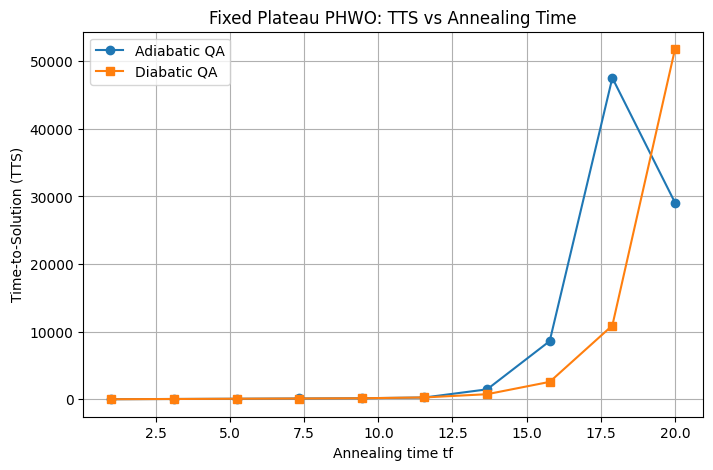

In [ ]:
# jj_annealer_simulation.py
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Problem: Fixed Plateau PHWO
# -----------------------------
def fixed_plateau(n, l=3, u=8):
    """Return the cost function for Fixed Plateau PHWO"""
    def cost(x):
        hw = np.sum(x)
        if l < hw < u:
            return u - 1
        else:
            return hw
    return cost

# -----------------------------
# Quantum Annealing
# -----------------------------
def annealing_schedule(t, tf, mode="adiabatic"):
    """Linear adiabatic or diabatic schedule"""
    if mode == "adiabatic":
        return t / tf
    elif mode == "diabatic":
        return np.sin(np.pi/2 * t/tf) ** 2
    else:
        raise ValueError("Unknown mode")

def q_annealer(n, cost_func, tf=10, steps=100, mode="adiabatic"):
    """Quantum annealing simulation using PennyLane"""
    dev = qml.device("default.qubit", wires=n)

    @qml.qnode(dev)
    def circuit(params):
        # Apply Hadamards for uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)
        # Evolve with Trotterized Hamiltonian
        dt = tf / steps
        for step in range(steps):
            s = annealing_schedule(step*dt, tf, mode)
            # Driver: transverse field
            for i in range(n):
                qml.RX(2 * (1 - s) * dt, wires=i)
            # Problem Hamiltonian
            for i in range(2**n):
                x = np.array(list(np.binary_repr(i, width=n)), dtype=int)
                Hx = cost_func(x)
                qml.MultiRZ(2 * s * Hx * dt, wires=list(range(n)))
        return qml.probs(wires=range(n))

    probs = circuit(None)
    return probs

# -----------------------------
# Spin Vector Dynamics (classical)
# -----------------------------
def spin_vector_dynamics(n, cost_func, tf=10, dt=0.1):
    """Classical spin-vector approximation of QA"""
    theta = np.pi * np.ones(n) / 2  # start in superposition
    phi = np.zeros(n)
    t = 0
    steps = int(tf/dt)

    def V_SC(theta_vec):
        """Semi-classical potential <theta|H|theta>"""
        # sum over all bitstrings
        total = 0
        for i in range(2**n):
            x = np.array(list(np.binary_repr(i, width=n)), dtype=int)
            prob = np.prod([np.cos(theta_vec[j]/2)**(1-x[j]) * np.sin(theta_vec[j]/2)**x[j] for j in range(n)])
            total += cost_func(x) * prob**2
        return total

    for _ in range(steps):
        grad = np.zeros(n)
        eps = 1e-5
        for i in range(n):
            theta_up = np.copy(theta)
            theta_up[i] += eps
            grad[i] = (V_SC(theta_up) - V_SC(theta)) / eps
        # Euler update
        theta -= dt * grad
    return theta

# -----------------------------
# Time-to-Solution (TTS)
# -----------------------------
def compute_tts_opt(p_GS_func, tf_values, p_d=0.9):
    tts = [(tf * np.log(1 - p_d)) / np.log(1 - p_GS_func(tf)) for tf in tf_values]
    return min(tts)

# -----------------------------
# Helper: ground state probability
# -----------------------------
def p_gs(probs):
    """Ground state probability (all zeros)"""
    return probs[0]

# -----------------------------
# Main simulation
# -----------------------------
if __name__ == "__main__":
    n = 4  # number of qubits
    cost = fixed_plateau(n, l=1, u=3)
    tf_list = np.linspace(1, 20, 10)

    tts_adiabatic = []
    tts_diabatic = []

    for tf in tf_list:
        # Adiabatic
        probs_adi = q_annealer(n, cost, tf=tf, steps=100, mode="adiabatic")
        tts_adiabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_adi)))

        # Diabatic
        probs_dia = q_annealer(n, cost, tf=tf, steps=100, mode="diabatic")
        tts_diabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_dia)))

    # Spin-vector dynamics
    theta_final = spin_vector_dynamics(n, cost, tf=10)
    print("Final spin angles (theta):", theta_final)

    # -----------------------------
    # Plot TTS vs annealing time
    # -----------------------------
    plt.figure(figsize=(8,5))
    plt.plot(tf_list, tts_adiabatic, 'o-', label="Adiabatic QA")
    plt.plot(tf_list, tts_diabatic, 's-', label="Diabatic QA")
    plt.xlabel("Annealing time tf")
    plt.ylabel("Time-to-Solution (TTS)")
    plt.title("Fixed Plateau PHWO: TTS vs Annealing Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# jj_annealer_simulation_large_n.py
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Problem: Fixed Plateau PHWO
# -----------------------------
def fixed_plateau(n, l=3, u=8):
    """Return the cost function for Fixed Plateau PHWO"""
    def cost(x):
        hw = np.sum(x)
        if l < hw < u:
            return u - 1
        else:
            return hw
    return cost

# -----------------------------
# Quantum Annealing
# -----------------------------
def annealing_schedule(t, tf, mode="adiabatic"):
    if mode == "adiabatic":
        return t / tf
    elif mode == "diabatic":
        return np.sin(np.pi/2 * t/tf) ** 2
    else:
        raise ValueError("Unknown mode")

def q_annealer(n, cost_func, tf=10, steps=100, mode="adiabatic"):
    """Quantum annealing simulation using PennyLane"""
    dev = qml.device("default.qubit", wires=n)

    @qml.qnode(dev)
    def circuit(params=None):
        # Uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)
        dt = tf / steps
        for step in range(steps):
            s = annealing_schedule(step*dt, tf, mode)
            for i in range(n):
                qml.RX(2 * (1 - s) * dt, wires=i)
            # Approximate problem Hamiltonian with sampled states
            for _ in range(10):  # sample 10 random bitstrings
                x = np.random.randint(0, 2, size=n)
                Hx = cost_func(x)
                qml.MultiRZ(2 * s * Hx * dt, wires=list(range(n)))
        return qml.probs(wires=range(n))

    return circuit()

# -----------------------------
# Spin Vector Dynamics (sampling)
# -----------------------------
def spin_vector_dynamics(n, cost_func, tf=10, dt=0.1, samples=1000):
    theta = np.pi * np.ones(n) / 2
    steps = int(tf / dt)

    def V_SC_sample(theta_vec):
        total = 0
        for _ in range(samples):
            x = np.random.randint(0, 2, size=n)
            prob = np.prod([np.cos(theta_vec[j]/2)**(1-x[j]) * np.sin(theta_vec[j]/2)**x[j] for j in range(n)])
            total += cost_func(x) * prob**2
        return total / samples

    for _ in range(steps):
        grad = np.zeros(n)
        eps = 1e-5
        for i in range(n):
            theta_up = np.copy(theta)
            theta_up[i] += eps
            grad[i] = (V_SC_sample(theta_up) - V_SC_sample(theta)) / eps
        theta -= dt * grad
    return theta

# -----------------------------
# Ground state probability
# -----------------------------
def p_gs(probs):
    return probs[0]

# -----------------------------
# TTS computation
# -----------------------------
def compute_tts_opt(p_GS_func, tf_values, p_d=0.9):
    tts = [(tf * np.log(1 - p_d)) / np.log(1 - p_GS_func(tf)) for tf in tf_values]
    return min(tts)

# -----------------------------
# Main simulation
# -----------------------------
if __name__ == "__main__":
    n = 10  # larger system
    cost = fixed_plateau(n, l=3, u=6)
    tf_list = np.linspace(1, 20, 10)

    tts_adiabatic = []
    tts_diabatic = []

    for tf in tf_list:
        # Quantum Annealing
        probs_adi = q_annealer(n, cost, tf=tf, steps=50, mode="adiabatic")
        probs_dia = q_annealer(n, cost, tf=tf, steps=50, mode="diabatic")
        tts_adiabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_adi)))
        tts_diabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_dia)))

    # Spin-vector dynamics
    theta_final = spin_vector_dynamics(n, cost, tf=10, dt=0.1, samples=2000)
    print("Final spin angles (theta) approx:", theta_final)

    # -----------------------------
    # Plot TTS
    # -----------------------------
    plt.figure(figsize=(8,5))
    plt.plot(tf_list, tts_adiabatic, 'o-', label="Adiabatic QA")
    plt.plot(tf_list, tts_diabatic, 's-', label="Diabatic QA")
    plt.xlabel("Annealing time tf")
    plt.ylabel("Time-to-Solution (TTS)")
    plt.title(f"Fixed Plateau PHWO (n={n} qubits)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import pennylane as qml
from pennylane import numpy as np

def hamming_weight_hamiltonian(n):
    """ H_P = sum_i |1><1|_i = sum_i (I - Z_i)/2 """
    coeffs = [0.5]*n + [-0.5]*n  # I/2 and -Z/2 for each qubit
    obs = [qml.Identity(i) for i in range(n)] + [qml.PauliZ(i) for i in range(n)]
    H = qml.Hamiltonian(coeffs, obs)
    return H


In [ ]:
def linear_schedule(t, tf):
    return t / tf

def quantum_annealing_schedule(H_D, H_P, tf, n_steps):
    """ Returns a list of Hamiltonians H(s) for each step s = t/tf """
    Hs = []
    for step in range(n_steps):
        s = linear_schedule(step, n_steps-1)
        Hs.append((1-s)*H_D + s*H_P)
    return Hs


In [ ]:
def evolve_state(Hs, state_init):
    """Simple first-order Trotter evolution"""
    state = state_init.copy()
    dt = 1.0 / len(Hs)
    for H in Hs:
        # PennyLane qubit unitary for small dt: U = exp(-i H dt)
        state = qml.math.expm(-1j * H.matrix @ dt) @ state
    return state


In [ ]:
def hamming_weight_expectation(state, n):
    """ <H_W> = sum_i <|1><1|_i> """
    exp = 0.0
    for i in range(n):
        Zi = np.kron(np.eye(2**i), np.kron([[0,0],[0,1]], np.eye(2**(n-i-1))))
        exp += np.real(state.conj().T @ Zi @ state)
    return exp


In [ ]:
import pennylane as qml
import numpy as np

# Number of qubits
n = 6

# Annealing parameters
tf = 10.0        # total anneal time
n_steps = 50
dt = tf / n_steps
beta = 30.0      # inverse temperature for SQA
N_tau = 64       # imaginary time slices for path integral

# Problem: Hamming weight
def f_hw(x):
    return np.sum(x)

# Device for statevector simulation
dev = qml.device("default.qubit", wires=n)

# Hamiltonians
def H_driver():
    return sum([qml.PauliX(i) for i in range(n)])

def H_problem(x):
    return sum([qml.Projector([1], wires=i) for i in range(n)])

# Trotterized SQA evolution
def sqa_step(params, state):
    s = params["s"]
    # Implement thermal relaxation by probabilistic updates
    # Placeholder: flip spins with probability p ~ exp(-beta * deltaE)
    for i in range(n):
        delta_E = f_hw(state) - f_hw(state ^ (1 << i))  # flip i-th qubit
        if np.random.rand() < np.exp(-beta * delta_E):
            state ^= (1 << i)
    return state

# Initialize
state = 0  # |000...0>
for step in range(n_steps):
    s = step / n_steps
    state = sqa_step({"s": s}, state)


/tmp/ipython-input-3394946111.py:35: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-beta * delta_E):


In [ ]:
import numpy as np

def sqa_simulation(n, N_tau, beta, n_steps, tf, cost_function):
    # Initialize random states for imaginary time slices
    states = np.zeros((N_tau, n), dtype=int)

    hamming_evolution = []

    for step in range(n_steps):
        s = step / n_steps
        for tau in range(N_tau):
            for i in range(n):
                # Flip spin i
                delta_E = cost_function(flip_bit(states[tau], i)) - cost_function(states[tau])
                if np.random.rand() < np.exp(-beta * delta_E):
                    states[tau, i] ^= 1
        # Record average Hamming weight across slices
        hamming_evolution.append(states.mean())

    return hamming_evolution

def flip_bit(state, i):
    new_state = state.copy()
    new_state[i] ^= 1
    return new_state


In [ ]:
import pennylane as qml
import numpy as np

n = 6
dev = qml.device("default.qubit", wires=n)
n_steps = 50
tf = 10.0
dt = tf / n_steps

def hamming_weight_circuit(params):
    s = params
    # Apply driver evolution
    for i in range(n):
        qml.RX((1-s)*dt, wires=i)
    # Apply problem evolution
    for i in range(n):
        qml.RZ(s*dt, wires=i)

@qml.qnode(dev)
def anneal_circuit(s):
    for i in range(n):
        qml.Hadamard(wires=i)  # |+> initial state
    hamming_weight_circuit(s)
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

hamming_evolution_quantum = []
for step in range(n_steps):
    s = step / n_steps
    expectation = anneal_circuit(s)
    # Map Z expectation to Hamming weight: <HW> = n*(1 - <Z>)/2
    hamming_evolution_quantum.append(n*(1 - np.mean(expectation))/2)


Running integrated experiment for n=8
Problem mapped to J,h (approx).
JJ MQT run done in 0.20s, best E = -1.0000
JJ Thermal run done in 0.18s, best E = -1.0000
SA done in 0.02s, best E = -4.0000
SQA (approx) done in 0.90s, final energy (approx) = -4.0000
AQA done in 0.29s, energy = -1.5576, p_gs = 0.000075
DQA done in 0.27s, energy = -0.9669, p_gs = 0.000427
SVD done, final theta = 1.5708


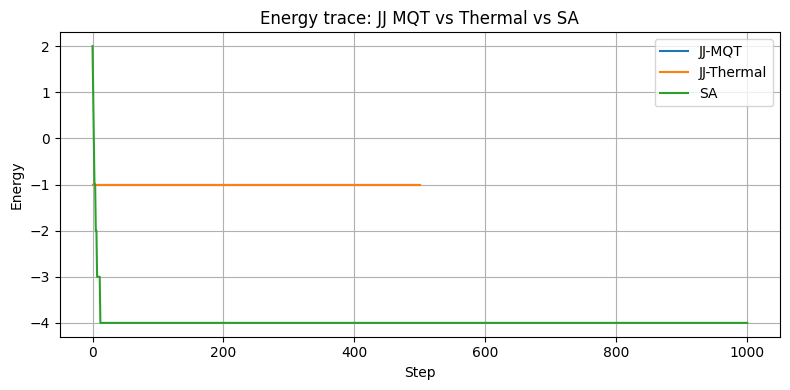

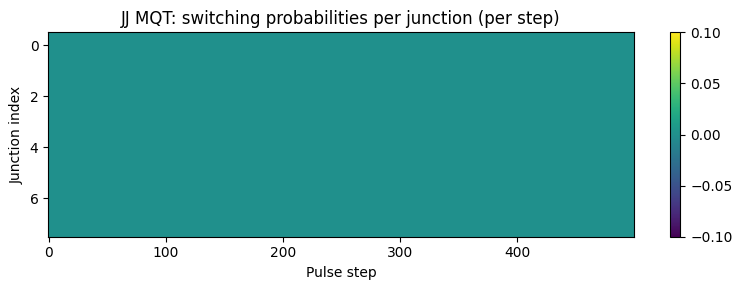

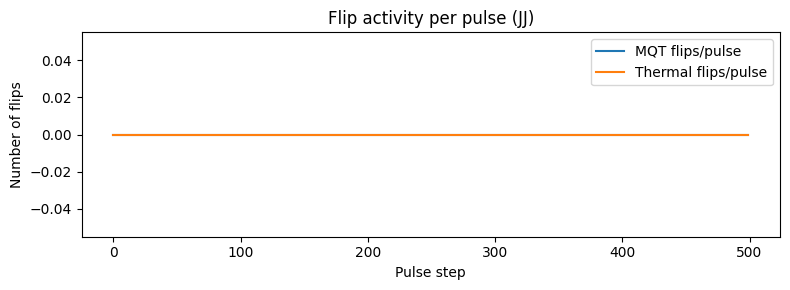

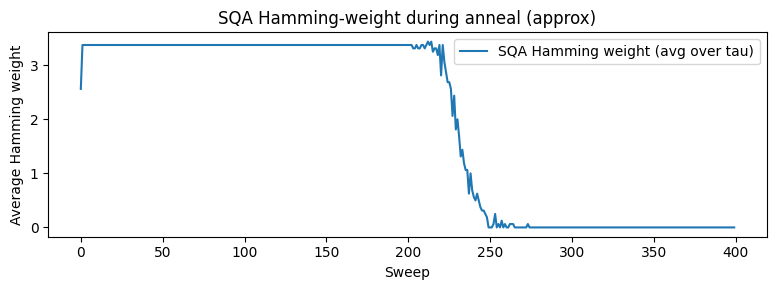

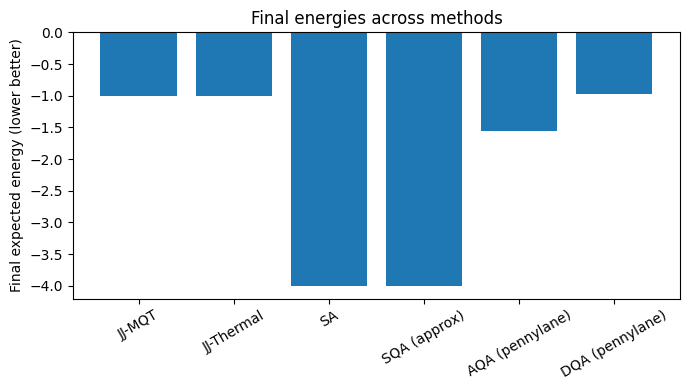

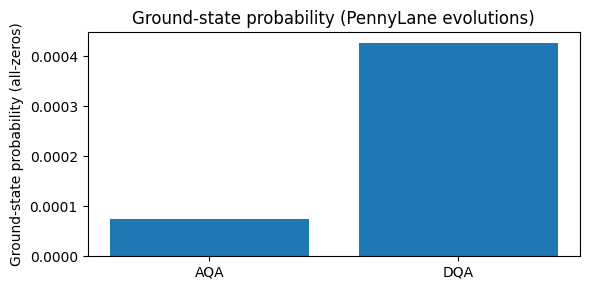

In [3]:
#!/usr/bin/env python3
"""
jj_quantum_integration.py

Integrated simulation:
- Josephson-junction array (MQT vs Thermal) pulse-step Monte Carlo
- Ising mapping (Max-Cut & PHWO Fixed Plateau)
- PennyLane quantum annealing: Adiabatic (AQA) and Diabatic (DQA) using Hamiltonian time evolution
- Simulated Quantum Annealing (SQA) via Suzuki-Trotter classical mapping (approximate)
- Simulated Annealing (SA) baseline and Spin Vector Dynamics (SVD)
- Visualizations: energy traces, flip heatmaps, tunneling probs, Hamming-weight traces

Author: Generated by assistant
"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import time
import math
import copy

# Try to import PennyLane device lightning for speed; fall back to default.qubit
try:
    import pennylane as qml
    from pennylane import numpy as pnp
    qml.device  # ensure present
except Exception as e:
    raise RuntimeError("PennyLane is required. Install with `pip install pennylane`") from e

# -----------------------------
# JJ physics utilities (from your jj_physics)
# -----------------------------
h = 6.62607015e-34
hbar = 1.054571817e-34
e = 1.602176634e-19
phi0 = h / (2 * e)
kb = 1.380649e-23

DEFAULT_Ic = 1.0e-6
DEFAULT_C = 1.0e-12
DEFAULT_EJ = phi0 * DEFAULT_Ic / (2 * np.pi)


def omega_p(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C) -> float:
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return np.sqrt(2.0 * e * Ic / (hbar * C)) * (1.0 - i**2)**0.25


def delta_U(i_reduced: float, EJ: float = DEFAULT_EJ) -> float:
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return 2.0 * EJ * (np.sqrt(1.0 - i**2) - i * np.arccos(i))


def gamma_th(i_reduced: float, T: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
             EJ: float = DEFAULT_EJ) -> float:
    if T <= 0.0:
        return 0.0
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    exponent = - dU / (kb * T)
    if exponent < -700:
        return 0.0
    return (op / (2.0 * np.pi)) * np.exp(exponent)


def gamma_mqt(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
              EJ: float = DEFAULT_EJ, hbar_eff: float = hbar) -> float:
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    arg = 36.0 * dU / (5.0 * hbar_eff * op)
    if arg > 700:
        return 0.0
    factor = max(1e-300, (864.0 * dU) / (hbar_eff * op))
    pref = (op / (2.0 * np.pi)) * np.sqrt(factor)
    return pref * np.exp(-arg)


def P_switch(i_reduced: float, pulse_s: float, T: float = None,
             Ic: float = DEFAULT_Ic, C: float = DEFAULT_C, EJ: float = DEFAULT_EJ) -> float:
    if pulse_s <= 0.0:
        return 0.0
    gamma = gamma_mqt(i_reduced, Ic=Ic, C=C, EJ=EJ) if T is None else gamma_th(i_reduced, T, Ic=Ic, C=C, EJ=EJ)
    lam = gamma * pulse_s
    lam = float(np.clip(lam, 0.0, 50.0))
    return 1.0 - np.exp(-lam)


# -----------------------------
# Ising mapping (ising_map)
# -----------------------------
def graph_to_Ising_J(adj_matrix: np.ndarray) -> np.ndarray:
    A = np.array(adj_matrix, dtype=float)
    if A.shape[0] != A.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    J = -A.copy()
    np.fill_diagonal(J, 0.0)
    return J


def ising_energy(s: np.ndarray, J: np.ndarray, h: np.ndarray = None) -> float:
    s = np.array(s, dtype=float).reshape(-1)
    J = np.array(J, dtype=float)
    if h is None:
        h = np.zeros_like(s)
    return -0.5 * float(s @ J @ s) - float(np.dot(h, s))


def random_weighted_graph(N: int, p_edge: float = 0.3, w_scale: float = 1.0, seed: int = None):
    rng = np.random.default_rng(seed)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i + 1, N):
            if rng.random() < p_edge:
                val = rng.uniform(0.5, 1.5) * w_scale
                A[i, j] = val
                A[j, i] = val
    return A


# Fixed Plateau PHWO generator (for benchmarking)
def fixed_plateau_cost_fn(n, l=3, u=8):
    def f(x_bits):
        hw = int(np.sum(x_bits))
        if l < hw < u:
            return u - 1
        else:
            return hw
    return f


# Convert classical cost f(x) (defined on bitstring x) to Ising J and h (approx)
# For demonstration we construct diagonal Hamiltonian coefficients by summing contributions.
def cost_function_to_Jh_from_enumeration(n, cost_fn):
    # enumerate 2^n states when n is small (n <= 16 recommended)
    Nstates = 1 << n
    # we want to find J,h such that E(x) = const + -0.5 s^T J s - h^T s approximately equals cost(x) for s in {+1,-1}
    # We'll build linear regression: for all x, features = pairwise products and single spins
    # Solve least squares for coefficients. This is approximate and for small n only.
    X = []
    y = []
    for xint in range(Nstates):
        bits = np.array(list(np.binary_repr(xint, width=n)), dtype=int)
        s = 2 * bits - 1  # map 0->-1,1->+1
        features = []
        # pairwise s_i s_j (i<j)
        for i in range(n):
            for j in range(i+1, n):
                features.append(s[i] * s[j])
        # linear terms s_i
        for i in range(n):
            features.append(s[i])
        X.append(features)
        y.append(cost_fn(bits))
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    # Solve linear least squares: X w = y
    w, *_ = np.linalg.lstsq(X, y, rcond=None)
    # unpack into J and h by mapping coefficients appropriately
    J = np.zeros((n, n), dtype=float)
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            J[i, j] = w[idx]
            J[j, i] = w[idx]
            idx += 1
    h = np.zeros(n)
    for i in range(n):
        h[i] = w[idx]
        idx += 1
    # The Ising energy E_ising(s) = -0.5 s^T J s - h^T s should approx equal cost(x)
    return J, h


# -----------------------------
# JJ-array pulse-step Monte Carlo (MQT vs Thermal)
# -----------------------------
def local_field_to_reduced_bias(h_eff, i0=0.5, alpha=0.45, beta=1.0):
    h_eff = np.array(h_eff, dtype=float)
    return np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)


def jj_array_simulator(J, h=None, pulse_s=10e-6, T=None,
                       i0=0.5, alpha=0.45, beta_map=1.0,
                       n_steps=1000, seed=None, verbose=False):
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    # initial spins +/-1
    s = rng.choice([-1, 1], size=N)
    energies = [ising_energy(s, J, h)]
    flips_record = np.zeros(n_steps, dtype=int)
    tunneling_probs = np.zeros((n_steps, N))
    best_E = energies[0]
    best_s = s.copy()

    for t in range(n_steps):
        h_eff = J @ s + h
        i_reduced = local_field_to_reduced_bias(h_eff, i0=i0, alpha=alpha, beta=beta_map)
        # compute switch prob per junction
        P = np.array([P_switch(float(i_reduced[k]), pulse_s, T) for k in range(N)])
        tunneling_probs[t, :] = P
        rand = rng.random(size=N)
        flips = (rand < P)
        flips_record[t] = flips.sum()
        s[flips] *= -1
        E = ising_energy(s, J, h)
        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()
        if verbose and (t % max(1, n_steps // 10) == 0):
            print(f"JJ sim [{t}/{n_steps}] E={E:.3f} best={best_E:.3f} flips={flips_record[t]}")
    return {
        'energies': np.array(energies),
        'final_s': s.copy(),
        'best_E': best_E,
        'best_s': best_s,
        'flips_record': flips_record,
        'tunneling_probs': tunneling_probs
    }


# -----------------------------
# Simulated Annealing (classical)
# -----------------------------
def simulated_annealing(J, h=None, T_start=5.0, T_end=0.1, n_steps=1000, seed=None):
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    E = ising_energy(s, J, h)
    best_E = E
    best_s = s.copy()
    energies = [E]
    temps = np.linspace(T_start, T_end, n_steps)
    for t, T in enumerate(temps):
        i = rng.integers(0, N)
        s_new = s.copy()
        s_new[i] *= -1
        E_new = ising_energy(s_new, J, h)
        dE = E_new - E
        if dE < 0 or rng.random() < np.exp(-dE / (kb * max(T, 1e-300))):
            s = s_new
            E = E_new
        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()
    return {'energies': np.array(energies), 'final_s': s, 'best_E': best_E, 'best_s': best_s}


# -----------------------------
# Spin Vector Dynamics (SVD) - symmetric reduction
# -----------------------------
def spin_vector_dynamics_symmetric(n, cost_fn, tf=10.0, n_steps=1000):
    # Solve symmetric SVD ODEs for theta(s), phi(s) as in paper.
    # We'll integrate Euler-ish for simplicity.
    dt = tf / n_steps
    # initial angles correspond to uniform superposition: theta=pi/2, phi=0
    theta = np.pi / 2.0
    phi = 0.0

    def VsymSC(theta_val, phi_val, s):
        # uses the symmetric potential expression: sum_w f(w) * comb(n,w) sin^{2w}(theta/2) cos^{2(n-w)}(theta/2)
        total = 0.0
        for w in range(0, n + 1):
            x = np.zeros(n, dtype=int)
            # Vsym built from cost on Hamming weight w:
            # Evaluate f(w) by setting a sample bitstring with weight w
            bits = np.array([1] * w + [0] * (n - w))
            fval = cost_fn(bits)
            comb = math.comb(n, w)
            p = (math.sin(theta_val / 2.0) ** 2) ** w * (math.cos(theta_val / 2.0) ** 2) ** (n - w)
            total += fval * comb * p
        # driver part
        driver = (1.0 - s) * n / 2.0 * (1.0 - math.cos(phi) * math.sin(theta))
        return driver + s * total

    # Euler integration for symmetric eqns (coarse)
    thetas = []
    phis = []
    for step in range(n_steps):
        s = step / n_steps
        # numeric derivatives (small eps)
        eps = 1e-6
        dV_dtheta = (VsymSC(theta + eps, phi, s) - VsymSC(theta - eps, phi, s)) / (2 * eps)
        dV_dphi = (VsymSC(theta, phi + eps, s) - VsymSC(theta, phi - eps, s)) / (2 * eps)
        # equations (D13) approximate (rescale so updates stable)
        theta_dot = (2.0 / n) * (1.0 / math.sin(theta + 1e-9)) * dV_dphi
        phi_dot = -(2.0 / n) * (1.0 / math.sin(theta + 1e-9)) * dV_dtheta
        theta = theta + dt * theta_dot
        phi = phi + dt * phi_dot
        thetas.append(theta)
        phis.append(phi)
    return {'theta_trace': np.array(thetas), 'phi_trace': np.array(phis), 'theta_final': theta, 'phi_final': phi}


# -----------------------------
# Simulated Quantum Annealing (SQA) - Suzuki-Trotter classical mapping (approx)
# -----------------------------
def sqa_simulation(J, h=None, n_tau=16, beta=10.0, n_sweeps=500, seed=None):
    """
    Approximate SQA via classical Monte Carlo on a +1/-1 lattice of shape (n, n_tau)
    Hamiltonian: sum_tau H_problem(s_tau) - K sum_{i, tau} s_{i,tau} s_{i,tau+1}
    K is transverse-field induced coupling. We pick K = 0.5 * log(coth(beta*Gamma/n_tau))
    We'll implement a simple anneal where Gamma is decreased from gamma_init -> 0 along sweeps.
    This is an approximation but captures the idea of thermal relaxation after minimum gap.
    """
    rng = np.random.default_rng(seed)
    n = J.shape[0]
    if h is None:
        h = np.zeros(n)
    # initialize random spins on (n, n_tau)
    spins = rng.choice([-1, 1], size=(n, n_tau))
    # schedule gamma -> affects K
    gamma_init = 1.0
    gamma_final = 0.01
    energies_trace = []
    hamming_trace = []
    for sweep in range(n_sweeps):
        # linear schedule for gamma
        gamma = gamma_init + (gamma_final - gamma_init) * (sweep / max(1, n_sweeps - 1))
        # coupling K (standard mapping approx)
        # to avoid numerical issues we use K = 0.5 * np.log(np.cosh(2*beta*gamma/n_tau)) as a heuristic
        # (many variants exist in the literature; this is a practical choice)
        arg = max(1e-12, 2.0 * beta * gamma / n_tau)
        K = 0.5 * np.log(np.cosh(arg))
        # sweep over all Trotter slices and spins
        for tau in range(n_tau):
            for i in range(n):
                # compute delta E for flipping spin i,tau
                # problem energy part
                s_old = spins[i, tau]
                # local energy from J and h in slice tau
                s_slice = spins[:, tau]
                deltaE_problem = 0.0
                # energy change due to flipping spin i: ΔE = E_new - E_old
                deltaE_problem = 2.0 * s_old * (0.5 * (J[i, :] @ s_slice) + h[i])
                # coupling to neighbors in tau direction
                s_up = spins[i, (tau - 1) % n_tau]
                s_dn = spins[i, (tau + 1) % n_tau]
                deltaE_coupling = 2.0 * s_old * (-K * (s_up + s_dn))
                deltaE = deltaE_problem + deltaE_coupling
                # Metropolis at temperature T = 1/beta
                if deltaE <= 0 or rng.random() < np.exp(-beta * deltaE):
                    spins[i, tau] = -s_old
        # record approximate physical quantities: average problem energy across slices and avg Hamming weight
        energy_total = 0.0
        hw_total = 0.0
        for tau in range(n_tau):
            s_slice = spins[:, tau]
            energy_total += ising_energy(s_slice, J, h)
            hw_total += 0.5 * (n - np.sum(s_slice))  # bits (0/1) count
        energies_trace.append(energy_total / n_tau)
        hamming_trace.append(hw_total / n_tau)
    return {'energies_trace': np.array(energies_trace), 'hamming_trace': np.array(hamming_trace), 'final_spins': spins}


# -----------------------------
# PennyLane AQA & DQA (construct Hamiltonian and TimeEvolution)
# -----------------------------
def ising_to_pennylane_hamiltonian(J, h):
    """Build qml.Hamiltonian with correct wire-specified PauliZ ops."""
    coeffs = []
    ops = []
    n = J.shape[0]
    # pairwise terms
    for i in range(n):
        for j in range(i + 1, n):
            if abs(J[i, j]) > 1e-12:
                coeffs.append(-0.5 * J[i, j])  # choose sign so mapping aligns with ising_energy def
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    # local fields
    for i in range(n):
        if abs(h[i]) > 1e-12:
            coeffs.append(-h[i])
            ops.append(qml.PauliZ(i))
    # If ops is empty (rare), create zero Hamiltonian
    if len(ops) == 0:
        ops = [qml.Identity(0)]
        coeffs = [0.0]
    return qml.Hamiltonian(coeffs, ops)


def run_pennylane_anneal(J, h=None, tf=5.0, n_steps=100, mode='adiabatic', device_name='default.qubit', wires_limit=16):
    """
    Run Trotterized time evolution with PennyLane's ApproxTimeEvolution template.
    mode: 'adiabatic' (linear s) or 'diabatic' (fast sin^2 schedule)
    Note: default.qubit supports qml.templates.ApproxTimeEvolution for small circuits.
    """
    n = J.shape[0]
    if h is None:
        h = np.zeros(n)
    H_problem = ising_to_pennylane_hamiltonian(J, h)
    # choose device
    dev = qml.device(device_name, wires=n)

    @qml.qnode(dev)
    def anneal_circuit():
        # start in uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)
        # Trotterized evolution
        dt = tf / n_steps
        for step in range(n_steps):
            t = step * dt
            if mode == 'adiabatic':
                s = t / tf
            elif mode == 'diabatic':
                s = math.sin((math.pi / 2.0) * (t / tf)) ** 2
            else:
                raise ValueError("mode must be 'adiabatic' or 'diabatic'")
            # driver part: (1-s) * sum X_i  => implement as RX pulses
            # small-angle RX approximating evolution under X
            for i in range(n):
                qml.RX(2.0 * (1.0 - s) * dt, wires=i)
            # problem Hamiltonian evolution: exp(-i s H_problem dt)
            # use ApproxTimeEvolution for the Hamiltonian
            qml.templates.ApproxTimeEvolution(H_problem, s * dt, 1)
        # return final state probabilities (full) or expectation of H_problem
        probs = qml.probs(wires=range(n))
        return probs

    probs = anneal_circuit()
    # compute expected energy from probs (classical)
    energy = 0.0
    for idx, p in enumerate(probs):
        bits = np.array(list(np.binary_repr(idx, width=n)), dtype=int)
        s = 2 * bits - 1
        energy += p * ising_energy(s, J, h)
    # ground-state prob (all zeros)
    p_gs = float(probs[0])
    return {'probs': probs, 'energy': energy, 'p_gs': p_gs}


# -----------------------------
# Helper: plotting utilities
# -----------------------------
def plot_energy_traces(traces, labels, title="Energy trace", xlabel="Step", ylabel="Energy"):
    plt.figure(figsize=(8, 4))
    for tr, lab in zip(traces, labels):
        plt.plot(tr, label=lab)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


def plot_heatmap(matrix, title="Heatmap", xlabel="Time", ylabel="Junction"):
    plt.figure(figsize=(8, 3))
    plt.imshow(matrix.T, aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()


# -----------------------------
# Main demo experiment
# -----------------------------
def example_experiment(n=8, problem='fixed_plateau'):
    """
    Runs an integrated experiment:
    - builds problem (PHWO fixed plateau)
    - maps to J,h via enumeration (small n)
    - runs: JJ-array MQT (T=None), JJ-array Thermal (T>0), SA, SQA, AQA, DQA, SVD
    - plots summary and saves figures
    """
    assert n <= 12, "n recommended <= 12 for enumeration-based mapping and PennyLane default.qubit"
    print(f"Running integrated experiment for n={n}")

    # Build cost function
    if problem == 'fixed_plateau':
        cost_fn = fixed_plateau_cost_fn(n, l=2, u=4)  # choose small plateau for small n
    else:
        # default: random Max-Cut
        A = random_weighted_graph(n, p_edge=0.25, w_scale=1.0, seed=123)
        J = graph_to_Ising_J(A)
        cost_fn = None

    if problem == 'fixed_plateau':
        # map cost function to J,h by least-squares enumeration (approx.)
        J, h = cost_function_to_Jh_from_enumeration(n, cost_fn)
    else:
        # assume J constructed above
        J = J
        h = np.zeros(n)

    print("Problem mapped to J,h (approx).")

    # JJ-array MQT (quantum tunneling dominated)
    start = time.time()
    res_mqt = jj_array_simulator(J, h=h, pulse_s=10e-6, T=None,
                                n_steps=500, seed=1, verbose=False)
    t_mqt = time.time() - start
    print(f"JJ MQT run done in {t_mqt:.2f}s, best E = {res_mqt['best_E']:.4f}")

    # JJ-array Thermal (classical thermal escapes)
    start = time.time()
    res_th = jj_array_simulator(J, h=h, pulse_s=10e-6, T=0.05,  # 50 mK typical
                                n_steps=500, seed=1, verbose=False)
    t_th = time.time() - start
    print(f"JJ Thermal run done in {t_th:.2f}s, best E = {res_th['best_E']:.4f}")

    # Simulated Annealing baseline
    start = time.time()
    res_sa = simulated_annealing(J, h=h, T_start=5.0, T_end=0.01, n_steps=1000, seed=2)
    t_sa = time.time() - start
    print(f"SA done in {t_sa:.2f}s, best E = {res_sa['best_E']:.4f}")

    # SQA
    start = time.time()
    res_sqa = sqa_simulation(J, h=h, n_tau=16, beta=20.0, n_sweeps=400, seed=3)
    t_sqa = time.time() - start
    print(f"SQA (approx) done in {t_sqa:.2f}s, final energy (approx) = {res_sqa['energies_trace'][-1]:.4f}")

    # PennyLane quantum annealing (AQA)
    start = time.time()
    res_aqa = run_pennylane_anneal(J, h=h, tf=2.5, n_steps=80, mode='adiabatic', device_name='default.qubit')
    t_aqa = time.time() - start
    print(f"AQA done in {t_aqa:.2f}s, energy = {res_aqa['energy']:.4f}, p_gs = {res_aqa['p_gs']:.6f}")

    # PennyLane quantum annealing (DQA diabatic)
    start = time.time()
    res_dqa = run_pennylane_anneal(J, h=h, tf=2.5, n_steps=80, mode='diabatic', device_name='default.qubit')
    t_dqa = time.time() - start
    print(f"DQA done in {t_dqa:.2f}s, energy = {res_dqa['energy']:.4f}, p_gs = {res_dqa['p_gs']:.6f}")

    # SVD (symmetric)
    res_svd = spin_vector_dynamics_symmetric(n, cost_fn if cost_fn is not None else (lambda b: ising_energy(2*b-1, J, h)),
                                             tf=2.5, n_steps=800)
    print(f"SVD done, final theta = {res_svd['theta_final']:.4f}")

    # -----------------------------
    # Plots
    # -----------------------------
    # Energy traces for JJ MQT and Thermal (we'll align lengths)
    plot_energy_traces([res_mqt['energies'], res_th['energies'], res_sa['energies']],
                       ['JJ-MQT', 'JJ-Thermal', 'SA'], title="Energy trace: JJ MQT vs Thermal vs SA")

    # Flip activity heatmap (JJ MQT)
    plot_heatmap(res_mqt['tunneling_probs'], title="JJ MQT: switching probabilities per junction (per step)", xlabel="Pulse step", ylabel="Junction index")

    # Flips per pulse comparison
    plt.figure(figsize=(8, 3))
    plt.plot(res_mqt['flips_record'], label='MQT flips/pulse')
    plt.plot(res_th['flips_record'], label='Thermal flips/pulse')
    plt.xlabel('Pulse step')
    plt.ylabel('Number of flips')
    plt.title('Flip activity per pulse (JJ)')
    plt.legend()
    plt.tight_layout()

    # SQA Hamming-weight trace
    plt.figure(figsize=(8, 3))
    plt.plot(res_sqa['hamming_trace'], label='SQA Hamming weight (avg over tau)')
    plt.xlabel('Sweep')
    plt.ylabel('Average Hamming weight')
    plt.title('SQA Hamming-weight during anneal (approx)')
    plt.legend()
    plt.tight_layout()

    # Compare final energies / p_gs
    plt.figure(figsize=(7, 4))
    methods = ['JJ-MQT', 'JJ-Thermal', 'SA', 'SQA (approx)', 'AQA (pennylane)', 'DQA (pennylane)']
    values = [res_mqt['energies'][-1], res_th['energies'][-1], res_sa['energies'][-1], res_sqa['energies_trace'][-1], res_aqa['energy'], res_dqa['energy']]
    plt.bar(methods, values)
    plt.ylabel('Final expected energy (lower better)')
    plt.title('Final energies across methods')
    plt.xticks(rotation=30)
    plt.tight_layout()

    # p_gs bar for quantum methods (AQA/DQA) and JJ (approx via final spin)
    p_gs_vals = [None, None, None, None, res_aqa['p_gs'], res_dqa['p_gs']]
    plt.figure(figsize=(6, 3))
    plt.bar(['AQA', 'DQA'], [res_aqa['p_gs'], res_dqa['p_gs']])
    plt.ylabel('Ground-state probability (all-zeros)')
    plt.title('Ground-state probability (PennyLane evolutions)')
    plt.tight_layout()

    plt.show()

    return {
        'J': J, 'h': h,
        'res_mqt': res_mqt, 'res_th': res_th, 'res_sa': res_sa,
        'res_sqa': res_sqa, 'res_aqa': res_aqa, 'res_dqa': res_dqa, 'res_svd': res_svd
    }


if __name__ == "__main__":
    # run demo with n=8 (adjustable)
    out = example_experiment(n=8, problem='fixed_plateau')
